In [1]:
# All required imports
# import tensorflow as tf
# print("GPU available", tf.test.is_gpu_available())
from joblib import Parallel, delayed
from tqdm import tqdm
import numba
from typing import Tuple, List
from matchms import Spectrum
from matchms.typing import SpectrumType
import numpy as np
import pandas as pd
from pathlib import Path
import json

from matchms import Spectrum

from matchms.filtering import normalize_intensities
from matchms.filtering import require_minimum_number_of_peaks
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import add_losses

def process_spectrum(spectrum):
    spectrum = select_by_mz(spectrum, mz_from=10.0, mz_to=1000.0)
    spectrum = normalize_intensities(spectrum)
    spectrum = select_by_relative_intensity(spectrum, intensity_from=0.001)
    spectrum = reduce_to_number_of_peaks(spectrum, n_max=1000)
    spectrum = require_minimum_number_of_peaks(spectrum, n_required=5)
    return spectrum


def get_ref_spectra_from_df(spectra_df, limit=None):
    # This function will take a dataframe with spectra and return a list of matchms spectra
    # Argh, This function is annoyingly slow. Added simple parallelization.
    
    # for index, row in spectra_df.iterrows():
    def fn(index, row):
        pbid = row["pbid"]
        precursor_mz = row["precursor_mz"]
        smiles = row["pb_smiles"]
        inchikey = row["pb_inchikey"]
        mz_array = np.array(json.loads(row["peaks_mz"]))
        intensity_array = np.array(json.loads(row["peaks_intensities"]))
        sp = Spectrum(mz=mz_array, intensities=intensity_array,
                        metadata={'id': pbid, 
                                'precursor_mz': precursor_mz, 
                                'smiles': smiles, 
                                'inchikey': inchikey}) 
        sp = process_spectrum(sp)
        return sp
    if limit is not None:
        spectra_df = spectra_df.head(limit)
    spectra = Parallel(-2)(delayed(fn)(index, row) for index, row in tqdm(spectra_df.iterrows(), total=len(spectra_df)) )
    spectra = [s for s in spectra if s is not None]
    return spectra

In [2]:
ref_spectra_df_path = Path("data/input/example_dataset_tornike.csv")
ref_spectra_df = pd.read_csv(ref_spectra_df_path)
large_references = get_ref_spectra_from_df(ref_spectra_df, limit=10000)

100%|██████████| 10000/10000 [00:08<00:00, 1229.28it/s]


In [49]:
N = 10
M = 5
queries = large_references[:N]
references = large_references[N:N+M]

print(f"Total iterations: {len(queries) * len(references)}")

Total iterations: 50


In [50]:
from numba import cuda

In [51]:
def spectra_peaks_to_tensor(spectra: list, fill: float):
    sp_max_shape = max(len(s.peaks) for s in spectra)
    mz = np.full((len(spectra), sp_max_shape), fill, 'float32')
    int = np.full((len(spectra), sp_max_shape), fill, 'float32')
    batch = np.zeros(len(spectra),dtype=np.int32)
    for i, s in enumerate(spectra):
        arr = s.peaks.to_numpy
        mz[i, :len(s.peaks)] = arr[...,0] 
        int[i, :len(s.peaks)] = arr[...,1]
        batch[i] = len(s.peaks)
    return mz, int, batch

In [52]:
np.set_printoptions(precision=3)

In [62]:
from numba.cuda.cudadrv.devicearray import DeviceNDArray
from numba import types
from numba.cuda import float32x3
import math

rmz_bs, rint_bs, references_cutoff = spectra_peaks_to_tensor(references, fill=-1e6)
qmz_bs, qint_bs, queries_cutoff  = spectra_peaks_to_tensor(queries, fill=-1e6)

rmz_cu = cuda.to_device(rmz_bs)
rint_cu = cuda.to_device(rint_bs)
rlen_cu = cuda.to_device(references_cutoff)

qmz_cu = cuda.to_device(qmz_bs)
qint_cu = cuda.to_device(qint_bs)
qlen_cu = cuda.to_device(queries_cutoff)

R,N = rmz_cu.shape
Q,M = qmz_cu.shape

K = 100

out = np.full((R, Q, 3), fill_value=-1, dtype='float32')
overflow = np.full((R, Q, 1), fill_value=0, dtype='uint8')
out_cu = cuda.to_device(out)
overflow_cu = cuda.to_device(overflow)        

@cuda.jit
def process(rmz: DeviceNDArray, 
            qmz: DeviceNDArray,
            rint: DeviceNDArray,
            qint: DeviceNDArray,
            rlen: DeviceNDArray, 
            qlen: DeviceNDArray,            
            out: DeviceNDArray,
            overflow: DeviceNDArray,
            
            R: int, 
            Q: int,
            M: int,
            N: int,
            
            tolerance: float,
            shift: float,
            mz_power: float,
            int_power: float,
            ):
    
    i,j = cuda.grid(2)
    thread_i = cuda.threadIdx.x
    thread_j = cuda.threadIdx.y
    match_cap = 100
    
    # Using shared `matches` array like we do, 
    # requires guaranteeing exclusive access for 0-thread
    if thread_i == 0 and thread_j == 0:
        
        if i < R and j < Q:
            
            spec1_mz = rmz[i]
            spec2_mz = qmz[j]
            
            spec1_int = rint[i]
            spec2_int = qint[j]
            
            lowest_idx = types.int32(0)
            num_match = types.int32(0)
            # For cuda 7.5, each SM (block, basically) has access to 
            # 64kb mem. This is allocating only (100,5,32) = 2kb
            # This can be increased if need be.
            matches = cuda.shared.array((match_cap,5), types.float32)
                    
            for peak1_idx in range(rlen[i]):
                mz = spec1_mz[peak1_idx]
                low_bound = mz - tolerance
                high_bound = mz + tolerance
                
                for peak2_idx in range(lowest_idx, qlen[j]):
                    mz2 = spec2_mz[peak2_idx] + shift
                    if mz2 > high_bound:
                        break
                    if mz2 < low_bound:
                        lowest_idx = peak2_idx
                    else:
                        if num_match < match_cap:
                            power_prod_spec1 = (spec1_mz[peak1_idx] ** mz_power) * (spec1_int[peak1_idx] ** int_power)
                            power_prod_spec2 = (spec2_mz[peak2_idx] ** mz_power) * (spec2_int[peak2_idx] ** int_power)
                            prod = power_prod_spec1 * power_prod_spec2
                            matches[num_match, 0] = prod
                            matches[num_match, 1] = peak1_idx
                            matches[num_match, 2] = peak2_idx
                            matches[num_match, 3] = power_prod_spec1
                            matches[num_match, 4] = power_prod_spec2
                            num_match += 1
                        else:
                            overflow[i, j, 0] = 1 # This is the errorcode for overflow
                            break

            if num_match == 0: 
                return
            
            # Extemely slow - Bubble sort
            
            score = types.float32(0.0)
            score_norm_spec1 = types.float32(0.0)
            score_norm_spec2 = types.float32(0.0)
            used_matches = types.int32(0)
            # We need two cases, bubble sort up to 50 elems is fine
            # if num_match < 50:
            for si in range(0, num_match):
                score_norm_spec1 += matches[si, 3] ** 2
                score_norm_spec2 += matches[si, 4] ** 2
                
            for si in range(0, num_match):
                max_prod = -1
                max_peak1_idx = -1
                max_peak2_idx = -1
                
                for sj in range(0, num_match):
                    if matches[sj,0] > max_prod:
                        max_prod = matches[sj,0]
                        max_peak1_idx = matches[sj, 1]
                        max_peak2_idx = matches[sj, 2]

                if max_prod > 0:
                    for sj in range(0, num_match):
                        if matches[sj, 1] == max_peak1_idx or matches[sj, 2] == max_peak2_idx:
                            matches[sj, 0] = -1 # "Remove" it
                    score += max_prod
                    used_matches += 1
                    
                if max_prod < 0:
                    break
                
            if score > 0:
                score = score / math.sqrt(score_norm_spec1 * score_norm_spec2)
                
            out[i,j,0] = score
            out[i,j,1] = used_matches

TPB = (1,1)
BPG_x = math.ceil(rmz_cu.shape[0] / TPB[0])
BPG_y = math.ceil(qmz_cu.shape[0] / TPB[0])
BPG = (BPG_x, BPG_y)

tolerance = types.float32(0.1)
shift = types.float32(0.0)
mz_power = types.float32(0.0)
int_power = types.float32(1.0)

process[BPG, TPB](
                rmz_cu, qmz_cu, 
                rint_cu, qint_cu, 
                rlen_cu, qlen_cu,
                out_cu, overflow_cu,
                
                R, Q, M, N,
                
                tolerance, shift, mz_power, int_power)
out_cu.copy_to_host(out)
overflow_cu.copy_to_host(overflow)

non_overflow = (1-overflow)
out_underflow = out * non_overflow

out_true = np.load('data/grid_outp.npy')
out_true_underflow = out_true * non_overflow

print("Correct without overflows:", np.allclose(out_underflow, out_true_underflow))
print("Correct with overflows:", np.allclose(out, out_true))

print(out[...,1])
print(out[...,0])
print(out_true[...,1])
print(out_true[...,0])

/home/tornikeo/miniconda3/envs/pb2/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 50 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Correct without overflows: False
Correct with overflows: False
[[ 5.  6.  8.  8. 13. 22. 33. 43. 52. 61.]
 [ 5.  6.  8.  8. 13. 21. 32. 41. 49. 59.]
 [12. 12. 12. 13. 13. 13. 11. 11. 10.  9.]
 [ 3.  4.  4.  5.  4.  4.  3.  3.  3.  3.]
 [ 3.  4.  4.  5.  4.  4.  3.  3.  3.  3.]]
[[0.059 0.077 0.102 0.175 0.143 0.187 0.301 0.481 0.648 0.801]
 [0.031 0.049 0.064 0.122 0.073 0.093 0.17  0.309 0.475 0.675]
 [0.995 0.996 0.995 0.963 0.914 0.852 0.73  0.489 0.267 0.146]
 [0.692 0.705 0.736 0.605 0.374 0.302 0.995 0.993 0.993 0.994]
 [0.597 0.627 0.747 0.812 0.673 0.615 0.994 0.99  0.991 0.992]]
[[ 5.  6.  8.  8. 13. 22. 33. 43. 52. 62.]
 [ 5.  6.  8.  8. 13. 21. 32. 41. 49. 59.]
 [12. 12. 12. 13. 13. 13. 11. 11. 10.  9.]
 [ 3.  4.  4.  5.  4.  4.  3.  3.  3.  3.]
 [ 3.  4.  4.  5.  4.  4.  3.  3.  3.  3.]]
[[0.026 0.034 0.065 0.112 0.162 0.238 0.385 0.566 0.743 0.916]
 [0.006 0.009 0.022 0.042 0.067 0.112 0.209 0.355 0.541 0.766]
 [0.984 0.997 0.996 0.964 0.915 0.853 0.704 0.461 0.232 0.104]


In [38]:
out[...,0]

array([[ 5.367e-02,  6.977e-02,  1.287e-01,  2.249e-01,  3.377e-01,
         5.318e-01,  1.058e+00,  1.420e+00,  1.898e+00,  0.000e+00],
       [ 1.020e-02,  1.600e-02,  3.745e-02,  7.308e-02,  1.206e-01,
         2.159e-01,  4.978e-01,  7.696e-01,  1.194e+00,  2.112e+00],
       [ 1.103e+00,  1.100e+00,  1.081e+00,  1.053e+00,  1.035e+00,
         1.035e+00,  1.053e+00,  6.292e-01,  3.221e-01,  1.812e-01],
       [ 3.667e-01,  3.612e-01,  3.029e-01,  2.162e-01,  1.668e-01,
         1.833e-01,  2.829e-01,  3.031e-01,  3.031e-01,  3.030e-01],
       [ 3.801e-01,  3.864e-01,  3.699e-01,  3.492e-01,  3.612e-01,
         4.492e-01,  7.117e-01,  7.622e-01,  7.622e-01,  7.621e-01],
       [ 1.936e-01,  2.130e-01,  2.648e-01,  3.489e-01,  4.415e-01,
         5.833e-01,  9.349e-01,  1.001e+00,  1.001e+00,  1.001e+00],
       [ 7.344e-02,  9.733e-02,  1.779e-01,  3.057e-01,  4.284e-01,
         5.805e-01,  9.345e-01,  1.000e+00,  1.001e+00,  1.001e+00],
       [ 3.832e-02,  6.351e-02,  1.525e-0

In [37]:
out_true_underflow[...,0]

array([[ 5.367e-02,  6.977e-02,  1.287e-01,  2.249e-01,  3.377e-01,
         5.318e-01,  1.058e+00,  1.420e+00,  1.898e+00,  0.000e+00],
       [ 1.020e-02,  1.600e-02,  3.745e-02,  7.308e-02,  1.206e-01,
         2.159e-01,  4.978e-01,  7.696e-01,  1.194e+00,  2.112e+00],
       [ 1.103e+00,  1.100e+00,  1.081e+00,  1.053e+00,  1.035e+00,
         1.035e+00,  1.053e+00,  6.292e-01,  3.221e-01,  1.812e-01],
       [ 3.667e-01,  3.612e-01,  3.029e-01,  2.162e-01,  1.668e-01,
         1.833e-01,  2.829e-01,  3.031e-01,  3.031e-01,  3.030e-01],
       [ 3.801e-01,  3.864e-01,  3.699e-01,  3.492e-01,  3.612e-01,
         4.492e-01,  7.117e-01,  7.622e-01,  7.622e-01,  7.621e-01],
       [ 1.936e-01,  2.130e-01,  2.648e-01,  3.489e-01,  4.415e-01,
         5.833e-01,  9.349e-01,  1.001e+00,  1.001e+00,  1.001e+00],
       [ 7.344e-02,  9.733e-02,  1.779e-01,  3.057e-01,  4.284e-01,
         5.805e-01,  9.345e-01,  1.000e+00,  1.001e+00,  1.001e+00],
       [ 3.832e-02,  6.351e-02,  1.525e-0

True
False


In [23]:
out_true.shape, overflow.shape

((20, 10, 3), (20, 10, 1))

In [18]:
(out * non_overflow[...,None])[...,1]

array([[ 5.,  6.,  8.,  8., 13., 22., 33., 43., 52.,  0.],
       [ 5.,  6.,  8.,  8., 13., 21., 32., 41., 49., 59.],
       [12., 12., 12., 13., 13., 13., 11., 11., 10.,  9.],
       [ 3.,  4.,  4.,  5.,  4.,  4.,  3.,  3.,  3.,  3.],
       [ 3.,  4.,  4.,  5.,  4.,  4.,  3.,  3.,  3.,  3.],
       [ 3.,  4.,  4.,  5.,  6.,  7.,  6.,  6.,  6.,  6.],
       [ 3.,  4.,  4.,  4.,  6.,  6.,  5.,  5.,  5.,  5.],
       [ 2.,  3.,  3.,  3.,  5.,  6.,  5.,  5.,  5.,  5.],
       [ 3.,  4.,  4.,  4.,  6.,  7.,  6.,  6.,  6.,  6.],
       [ 4.,  5.,  5.,  5.,  7.,  8.,  9.,  9.,  9.,  9.],
       [ 4.,  5.,  5.,  5.,  7.,  9., 10., 12., 13., 13.],
       [ 4.,  5.,  5.,  5.,  9., 11., 14., 17., 19., 21.],
       [ 4.,  5.,  5.,  5., 10., 12., 17., 21., 24., 28.],
       [ 3.,  4.,  4.,  4.,  8., 10., 17., 21., 23., 28.],
       [ 1.,  2.,  2.,  2.,  3.,  5., 12., 15., 17., 22.],
       [ 1.,  2.,  2.,  2.,  3.,  4.,  9., 12., 15., 21.],
       [ 1.,  2.,  2.,  2.,  2.,  3.,  8., 11., 14., 19.

In [8]:
raise

RuntimeError: No active exception to reraise

In [ ]:
batch_size = 4

for br in tqdm(range(0, math.ceil(len(references) / batch_size))):
    for bq in range(0, math.ceil(len(queries) / batch_size)):
        rmz_bs, rint_bs, references_cutoff = spectra_peaks_to_tensor(references[br:br+batch_size], fill=-1e6)
        qmz_bs, qint_bs, queries_cutoff  = spectra_peaks_to_tensor(queries[bq:bq+batch_size], fill=-1e6)

        
        rmz_cu = cuda.to_device(rmz_bs)
        rint_cu = cuda.to_device(rint_bs)
        rlen_cu = cuda.to_device(references_cutoff)

        qmz_cu = cuda.to_device(qmz_bs)
        qint_cu = cuda.to_device(qint_bs)
        qlen_cu = cuda.to_device(queries_cutoff)

        R,N = rmz_cu.shape
        Q,M = qmz_cu.shape

        K = 100

        out = np.full((R, Q, 3), fill_value=-1, dtype='float32')
        overflow = np.full((R, Q), fill_value=0, dtype='uint8')
        out_cu = cuda.to_device(out)
        overflow_cu = cuda.to_device(overflow)        

        TPB = (1,1)
        BPG_x = math.ceil(rmz_cu.shape[0] / TPB[0])
        BPG_y = math.ceil(qmz_cu.shape[0] / TPB[0])
        BPG = (BPG_x, BPG_y)

        tolerance = types.float32(0.1)
        shift = types.float32(0.0)
        mz_power = types.float32(0.0)
        int_power = types.float32(1.0)

        process[BPG, TPB](
                        rmz_cu, qmz_cu, 
                        rint_cu, qint_cu, 
                        rlen_cu, qlen_cu,
                        out_cu, overflow_cu,
                        
                        R, Q, M, N,
                        
                        tolerance, shift, mz_power, int_power)
        out_cu.copy_to_host(out)
        overflow_cu.copy_to_host(overflow)
        # print(overflow.sum())
        # print(np.allclose(np.load('data/grid_outp.npy'), out, atol=1e-2))
        # print(out.shape)
        # print(out[...,0,1])
        # print(overflow)

  0%|          | 0/8 [00:00<?, ?it/s]/home/tornikeo/miniconda3/envs/pb2/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 16 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
100%|██████████| 8/8 [00:00<00:00, 37.77it/s]


In [ ]:
overflow.mean()

0.0029296875

In [ ]:
np.argsort(out[..., ])

In [ ]:
out.shape

(32, 32, 100, 3)

In [ ]:
(out.nbytes * 32 * 32) / 1e9

1.2582912

In [ ]:
np.mean((out == -1), axis=(2,3)).mean()

0.849462890625

In [ ]:
out.shape

(32, 32, 77, 96, 2)

In [ ]:
512 / 32

16.0

In [ ]:
np.prod((512, 512, 71, 77, 2)) / 1e9

2.866282496

In [ ]:
z = out[...,0].ravel().astype('int32')
z.mean(), z.min(), z.max(), z.std()

(11.620976231783484, 0, 526, 20.412919474583756)

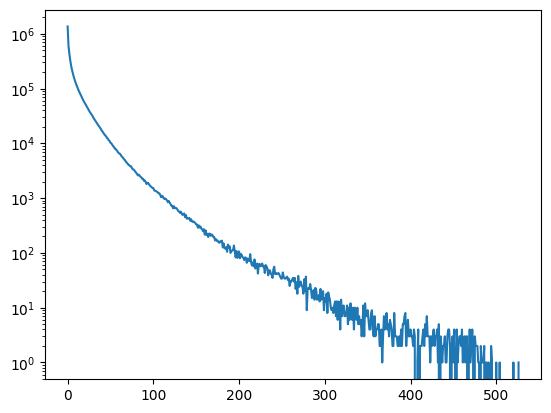

In [ ]:
import matplotlib.pyplot as plt 
plt.plot(np.bincount(z), )
# plt.xscale('log')
plt.yscale('log')

In [ ]:
qmz_cu.shape, rmz_cu.shape

((10, 71), (20, 77))

In [ ]:
raise
qmz_cu[0].copy_to_host(), rmz_cu.shape

(array([ 1.180654e+02,  1.250155e+02,  1.320811e+02,  1.330844e+02,
         1.435732e+02,  1.440810e+02,  1.445916e+02,  1.450786e+02,
         1.450844e+02,  1.540421e+02,  1.550454e+02,  1.680577e+02,
         2.851158e+02,  2.861193e+02, -1.000000e+06, -1.000000e+06,
        -1.000000e+06, -1.000000e+06, -1.000000e+06, -1.000000e+06,
        -1.000000e+06, -1.000000e+06, -1.000000e+06, -1.000000e+06,
        -1.000000e+06, -1.000000e+06, -1.000000e+06, -1.000000e+06,
        -1.000000e+06, -1.000000e+06, -1.000000e+06, -1.000000e+06,
        -1.000000e+06, -1.000000e+06, -1.000000e+06, -1.000000e+06,
        -1.000000e+06, -1.000000e+06, -1.000000e+06, -1.000000e+06,
        -1.000000e+06, -1.000000e+06, -1.000000e+06, -1.000000e+06,
        -1.000000e+06, -1.000000e+06, -1.000000e+06, -1.000000e+06,
        -1.000000e+06, -1.000000e+06, -1.000000e+06, -1.000000e+06,
        -1.000000e+06, -1.000000e+06, -1.000000e+06, -1.000000e+06,
        -1.000000e+06, -1.000000e+06, -1.000000e

In [ ]:
raise

TypeError: DeviceNDArrayBase.copy_to_device() missing 1 required positional argument: 'ary'

In [ ]:
import time

def collect_peak_pairs(spec1: np.ndarray, spec2: np.ndarray,
                       tolerance: float, shift: float = 0, mz_power: float = 0.0,
                       intensity_power: float = 1.0):
    # pylint: disable=too-many-arguments
    """Find matching pairs between two spectra.

    Args
    ----
    spec1:
        Spectrum peaks and intensities as numpy array.
    spec2:
        Spectrum peaks and intensities as numpy array.
    tolerance
        Peaks will be considered a match when <= tolerance appart.
    shift
        Shift spectra peaks by shift. The default is 0.
    mz_power:
        The power to raise mz to in the cosine function. The default is 0, in which
        case the peak intensity products will not depend on the m/z ratios.
    intensity_power:
        The power to raise intensity to in the cosine function. The default is 1.

    Returns
    -------
    matching_pairs : numpy array
        Array of found matching peaks.
    """
    matches = find_matches(spec1[:, 0], spec2[:, 0], tolerance, shift)
    # global a
    # a = matches
    # matches_op = find_matches_opt(spec1[:, 0], spec2[:, 0], tolerance, shift)
    # global b
    # b = matches_op
    # assert np.allclose(matches, matches_op)
    
    idx1 = [x[0] for x in matches]
    idx2 = [x[1] for x in matches]
    if len(idx1) == 0:
        return None
    matching_pairs = []
    for i, idx in enumerate(idx1):
        power_prod_spec1 = (spec1[idx, 0] ** mz_power) * (spec1[idx, 1] ** intensity_power)
        power_prod_spec2 = (spec2[idx2[i], 0] ** mz_power) * (spec2[idx2[i], 1] ** intensity_power)
        # print((idx, idx2[i], power_prod_spec1 * power_prod_spec2))
        # raise
        matching_pairs.append([idx, idx2[i], power_prod_spec1 * power_prod_spec2])
    # print(matching_pairs)
    # raise
    return np.array(matching_pairs.copy())


# @numba.njit
def find_matches(spec1_mz: np.ndarray, spec2_mz: np.ndarray,
                 tolerance: float, shift: float = 0) -> List[Tuple[int, int]]:
    """Faster search for matching peaks.
    Makes use of the fact that spec1 and spec2 contain ordered peak m/z (from
    low to high m/z).

    Parameters
    ----------
    spec1_mz:
        Spectrum peak m/z values as numpy array. Peak mz values must be ordered.
    spec2_mz:
        Spectrum peak m/z values as numpy array. Peak mz values must be ordered.
    tolerance
        Peaks will be considered a match when <= tolerance appart.
    shift
        Shift peaks of second spectra by shift. The default is 0.

    Returns
    -------
    matches
        List containing entries of type (idx1, idx2).

    """
    
    lowest_idx = 0
    matches = []
    for peak1_idx in range(spec1_mz.shape[0]):
        mz = spec1_mz[peak1_idx]
        low_bound = mz - tolerance
        high_bound = mz + tolerance
        for peak2_idx in range(lowest_idx, spec2_mz.shape[0]):
            mz2 = spec2_mz[peak2_idx] + shift
            if mz2 > high_bound:
                break
            if mz2 < low_bound:
                lowest_idx = peak2_idx
            else:
                matches.append((peak1_idx, peak2_idx))
                # print((peak1_idx, peak2_idx))
    # print(matches)
    return matches


@numba.njit(fastmath=True)
def score_best_matches(matching_pairs: np.ndarray, spec1: np.ndarray,
                       spec2: np.ndarray, mz_power: float = 0.0,
                       intensity_power: float = 1.0) -> Tuple[float, int]:
    """Calculate cosine-like score by multiplying matches. Does require a sorted
    list of matching peaks (sorted by intensity product)."""
    score = float(0.0)
    used_matches = int(0)
    used1 = set()
    used2 = set()
    for i in range(matching_pairs.shape[0]):
        if not matching_pairs[i, 0] in used1 and not matching_pairs[i, 1] in used2:
            score += matching_pairs[i, 2]
            used1.add(matching_pairs[i, 0])  # Every peak can only be paired once
            used2.add(matching_pairs[i, 1])  # Every peak can only be paired once
            # print(i, matching_pairs[i,0], matching_pairs[i,1], used_matches, score)
            used_matches += 1
    # print(score)
    # raise
    # Normalize score:
    spec1_power = spec1[:, 0] ** mz_power * spec1[:, 1] ** intensity_power
    
    spec2_power = spec2[:, 0] ** mz_power * spec2[:, 1] ** intensity_power

    # print(spec1_power)
    # print(spec2_power)
    # raise
    score_norm = (np.sum(spec1_power ** 2) ** 0.5 * np.sum(spec2_power ** 2) ** 0.5)
    # print(score, score_norm, used_matches)
    score = score/score_norm
    # print(score, "/", score_norm)
    # raise
    return score, used_matches


In [ ]:
start_collect_peaks = time.time()
pairs_to_score_list = []
scores = []
grid_outp = np.full((len(references), len(queries), 3), 
                    fill_value=-1, 
                    dtype='float32')
for i,spectrum_1 in tqdm(enumerate(references)):
    for j,spectrum_2 in enumerate(queries):
        spec1 = spectrum_1.peaks.to_numpy
        spec2 = spectrum_2.peaks.to_numpy
        
        matching_pairs = collect_peak_pairs(
                    spectrum_1.peaks.to_numpy, 
                    spectrum_2.peaks.to_numpy, 
                    tolerance=0.1,
                    shift=0.0, 
                    mz_power=0.0,
                    intensity_power=1.0
        )
        if matching_pairs is not None:
            # Store in grid
            grid_outp[i,j,0] = matching_pairs[0,0]
            grid_outp[i,j,1] = matching_pairs[0,1]
            grid_outp[i,j,2] = matching_pairs[0,2]
            matching_pairs = matching_pairs[np.argsort(matching_pairs[:, 2])[::-1], :] 
            pairs_to_score_list.append([ matching_pairs, spectrum_1, spectrum_2]) 
for matching_pairs, spectrum_1, spectrum_2 in tqdm(pairs_to_score_list):
    scores.append(score_best_matches(matching_pairs, spectrum_1.peaks.to_numpy, spectrum_2.peaks.to_numpy,
                                0.0, 1.0))
end_collect_peaks = time.time()
print("Time to collect matching pairs: ", end_collect_peaks - start_collect_peaks)

20it [00:00, 871.57it/s]
100%|██████████| 195/195 [00:00<00:00, 31363.19it/s]

Time to collect matching pairs:  0.033110857009887695


In [ ]:
print(grid_outp[...,0])
print(grid_outp[...,1])
print(grid_outp[...,2])

[[49. 49. 47. 47. 25. 20.  7.  1.  1.  0.]
 [54. 54. 52. 52. 30. 26. 10.  1.  1.  0.]
 [ 1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 2.  2.  2.  2.  1.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  0.  0.  0.  0.  0.  0.]
 [ 2.  2.  2.  2.  1.  0.  0.  0.  0.  0.]
 [ 2.  2.  2.  2.  1.  0.  0.  0.  0.  0.]
 [ 5.  5.  5.  5.  4.  0.  0.  0.  0.  0.]
 [ 8.  8.  8.  8.  7.  3.  3.  0.  0.  0.]
 [16. 16. 16. 16.  9.  6.  4.  0.  0.  0.]
 [28. 28. 28. 28. 19. 14.  6.  0.  0.  0.]
 [30. 30. 30. 30. 20. 15.  7.  1.  1.  0.]
 [29. 29. 29. 29. 21. 17.  9.  1.  1.  0.]
 [32. 32. 32. 32. 25. 21. 17.  1.  1.  0.]
 [33. 33. 33. 33. 33. 24. 18.  1.  1.  0.]
 [-1. -1. -1. -1. -1. 25. 20.  2.  2.  0.]
 [ 6.  6.  2.  2.  0.  0.  0.  0.  0.  0.]
 [ 8.  8.  6.  6.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  2.  5. 14. 22. 29. 37.]
 [ 1.  1. 

In [ ]:
pairs_to_score_list[0]

[array([[7.00000000e+01, 5.00000000e+00, 3.30030030e-02],
        [5.20000000e+01, 1.00000000e+00, 1.84744123e-02],
        [6.90000000e+01, 5.00000000e+00, 5.59559560e-03],
        [7.10000000e+01, 8.00000000e+00, 1.52285980e-03],
        [7.30000000e+01, 1.00000000e+01, 5.38289641e-04],
        [5.00000000e+01, 0.00000000e+00, 1.28455984e-04],
        [4.90000000e+01, 0.00000000e+00, 1.01638275e-04],
        [7.10000000e+01, 7.00000000e+00, 4.72404336e-05]]),
 Spectrum(precursor m/z=285.12, 74 fragments between 50.0 and 155.1),
 Spectrum(precursor m/z=285.12, 14 fragments between 118.1 and 286.1)]

In [ ]:
scores

[(0.02605932348386438, 5),
 (0.03442222082648898, 6),
 (0.06452274444206799, 8),
 (0.11209947205892355, 8),
 (0.1623664287234474, 13),
 (0.23840139483322562, 22),
 (0.3848047853392426, 33),
 (0.5657118496972595, 43),
 (0.7429066000116887, 52),
 (0.9162835881551422, 62),
 (0.005728378647648435, 5),
 (0.009132206272256797, 6),
 (0.021709608341931294, 8),
 (0.04213699303551976, 8),
 (0.06706815456959091, 13),
 (0.11193900110163978, 21),
 (0.20943092375678907, 32),
 (0.3547077252764144, 41),
 (0.5405889742079147, 49),
 (0.7662681701490394, 59),
 (0.9839733090233771, 12),
 (0.9972879869804555, 12),
 (0.9955911964844311, 12),
 (0.964456618462334, 13),
 (0.9148682500738545, 13),
 (0.8527410050476982, 13),
 (0.7035701317343943, 11),
 (0.4606751332163862, 11),
 (0.23167265520749364, 10),
 (0.10444423283199249, 9),
 (0.3253888505462898, 3),
 (0.32565130293613376, 4),
 (0.27739187239428803, 4),
 (0.196922979415211, 5),
 (0.14655759650837452, 4),
 (0.15012987464297978, 4),
 (0.18799849781377598, 3

In [ ]:
from itertools import product
start_collect_peaks = time.time()
queries_npy = [q.peaks.to_numpy.astype('float32') for q in queries]
references_npy = [q.peaks.to_numpy.astype('float32') for q in references]

def fn(spectrum_1, spectrum_2):
    matching_pairs = collect_peak_pairs(
                spectrum_1, 
                spectrum_2, 
                tolerance=0.1,
                shift=0.0, 
                mz_power=0.0,
                intensity_power=1.0
    ) 
    if matching_pairs is not None:
        return score_best_matches(matching_pairs, spectrum_1, spectrum_2, 0.0, 1.0)
    
total_len = len(references_npy) * len(queries_npy)
scores = Parallel(-1)(delayed(fn)(spectrum_1, spectrum_2)
                      for (spectrum_1, spectrum_2) in 
                      tqdm(product(references_npy,queries_npy), total=total_len))

end_collect_peaks = time.time()
print("Time to collect matching pairs: ", end_collect_peaks - start_collect_peaks)

  0%|          | 0/947000 [00:00<?, ?it/s]

100%|██████████| 947000/947000 [01:37<00:00, 9744.21it/s] 


Time to collect matching pairs:  97.95659852027893


In [ ]:
def spectra_peaks_to_tensor(spectra: list, fill: float):
    sp_max_shape = max(len(s.peaks) for s in spectra)
    sp = np.full((len(spectra), sp_max_shape, 2), fill, 'float32')
    batch = np.zeros(len(spectra),dtype=np.uint64)
    for i, s in enumerate(spectra):
        sp[i, :len(s.peaks)] = s.peaks.to_numpy
        batch[i] = len(s.peaks)
    return sp, batch

# queries = large_references[:1000]
# references = large_references[1000:]

references_batch, references_batch_size \
    = spectra_peaks_to_tensor(references, fill=-1e6)
queries_batch, queries_batch_size \
    = spectra_peaks_to_tensor(queries, fill=-1e6)

In [ ]:
np.save('data/references_mz.npy', references_batch[...,0])
np.save('data/references_int.npy', references_batch[...,1])
np.save('data/queries_mz.npy', queries_batch[...,0])
np.save('data/queries_int.npy', queries_batch[...,1])
# np.save('data/scores_100x100.npy', np.array(scores))

In [ ]:
load_scores_true = np.load('data/scores_100x100.npy')
print(load_scores_true)
print(load_scores_true.shape, load_scores_true.dtype)
print(np.sort(load_scores_true[:,0]))

FileNotFoundError: [Errno 2] No such file or directory: 'data/scores_100x100.npy'

In [ ]:
load_scores = np.load('data/results.npy')
print(load_scores)
print(load_scores.shape, load_scores.dtype)
print(np.sort(load_scores[:,0]))

[[0.0000000e+00 5.0000000e+00 2.9956270e-06 1.0000000e+00]
 [0.0000000e+00 6.0000000e+00 7.0604798e-04 5.0000000e+00]
 [0.0000000e+00 7.0000000e+00 2.6819189e-03 1.0000000e+01]
 ...
 [7.6410000e+03 9.9700000e+02 5.7682420e-05 1.0000000e+00]
 [7.6410000e+03 9.9800000e+02 2.6733984e-05 1.0000000e+00]
 [7.6410000e+03 9.9900000e+02 7.2767034e-06 1.0000000e+00]]
(65748867, 4) float32
[    0.     0.     0. ... 91697. 91697. 91697.]


In [ ]:
load_scores.nbytes / 1e9

1.051981872

In [ ]:
import matplotlib.pyplot as plt
plt.plot(load_scores[:,1] - load_scores_true[:len(load_scores[:,1]),1])

ValueError: operands could not be broadcast together with shapes (1740258,) (22970,) 